In [1]:
cd ..

/Users/muhammadfarooq/Codebase/thesis-experiment/Pith2Bark


In [2]:
from src.winner import winner_model_rings
from src.damage import merge_df
from src.damage import read_damage_min_max
from src.damage import read_damage_mean

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

2023-04-03 21:55:00.151744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import warnings
warnings.simplefilter('ignore')

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

random_state = 47
np.random.seed(random_state)

# Visual

In [5]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

# Configuration

In [6]:
# mode = max for monitro val_accuracy and val_prc

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [7]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2023-04-03 21:55:04.062849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
accuracy_sixteen_min_max = []
accuracy_thirtytwo_min_max = []
accuracy_sixteen_mean = []
accuracy_thirtytwo_mean = []

# Prepare Dataset

In [9]:
mse_url = "output/ringsranking_mse_sixteen.csv"
rings_url = "output/ringsranking_rings_sixteen.csv"
df_ringsranking_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/ringsranking_mse_thirtytwo.csv"
rings_url = "output/ringsranking_rings_thirtytwo.csv"
df_ringsranking_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur otsu) 12.829318845239923 (subseq)
Polar Pith Canny(blur otsu) 12.88055458721076 (subseq)


In [10]:
mse_url = "output/pine_mse_sixteen.csv"
rings_url = "output/pine_rings_sixteen.csv"
df_pine_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/pine_mse_thirtytwo.csv"
rings_url = "output/pine_rings_thirtytwo.csv"
df_pine_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur triangle) 19.888455438324574 (peaks)
Polar Pith Canny(blur triangle) 19.591747084408897 (peaks)


In [11]:
mse_url = "output/fur_mse_sixteen.csv"
rings_url = "output/fur_rings_sixteen.csv"
df_fur_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/fur_mse_thirtytwo.csv"
rings_url = "output/fur_rings_thirtytwo.csv"
df_fur_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur triangle) 13.428984012468806 (peaks)
Polar Pith Canny(blur triangle) 13.688767879960144 (peaks)


In [12]:
mse_url = "output/tracy_mse_sixteen.csv"
rings_url = "output/tracy_rings_sixteen.csv"
df_tracy_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/tracy_mse_thirtytwo.csv"
rings_url = "output/tracy_rings_thirtytwo.csv"
df_tracy_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Canny(triangle) 39.683736416974455 (peaks)
Polar Pith Canny(triangle) 39.48914666858598 (peaks)


In [13]:
mse_url = "output/data_mse_sixteen.csv"
rings_url = "output/data_rings_sixteen.csv"
df_data_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/data_mse_thirtytwo.csv"
rings_url = "output/data_rings_thirtytwo.csv"
df_data_thirtytwo = winner_model_rings(mse_url, rings_url)

Canny(triangle) 18.789996216404624 (subseq)
Canny(triangle) 18.871624925897343 (subseq)


In [14]:
#damage
damage_sixteen_url = "damage/damage_sixteen.csv"
damage_thirtytwo_url = "damage/damage_thirtytwo.csv"

#merge
df_merge_sixteen = merge_df(df_ringsranking_sixteen, df_pine_sixteen, df_fur_sixteen, df_tracy_sixteen, df_data_sixteen)
df_merge_thirtytwo = merge_df(df_ringsranking_thirtytwo, df_pine_thirtytwo, df_fur_thirtytwo, df_tracy_thirtytwo, df_data_thirtytwo)

df_damage_sixteen_min_max = read_damage_min_max(damage_sixteen_url, df_merge_sixteen)
df_damage_thirtytwo_min_max = read_damage_min_max(damage_thirtytwo_url, df_merge_thirtytwo)

df_damage_sixteen_mean = read_damage_mean(damage_sixteen_url, df_merge_sixteen)
df_damage_thirtytwo_mean = read_damage_mean(damage_thirtytwo_url, df_merge_thirtytwo)

In [15]:
df_damage_sixteen_min_max

,image,Damage,algo,line_1,line_2,line_3,line_4,line_5,line_6,line_7,...,line_11,line_12,line_13,line_14,line_15,line_16,min,max,mean,orig
0,2-34e23370868237a073d086fb64851017e9b2c8c9_859...,1,subseq,55,51,51,57,56,32,30,...,83,62,58,56,52,57,30,83,53.4375,87.000000
1,1-5d205d5ea6bafd3c2e038cf1139cdd5a9825388f_275...,1,subseq,97,94,96,75,77,75,74,...,76,62,55,51,69,64,51,97,72.7500,59.666667
2,1-11c00bf7cc3e03dc86bde8a20c8ab390b0b2f2a4_d5d...,0,subseq,8,11,13,19,17,10,16,...,13,11,28,18,15,8,8,28,13.3125,18.000000
3,2-8c5de8aa63e57b1e5d3a11ce4c4e2ded042b2ef3_069...,0,subseq,54,44,46,40,31,34,42,...,29,42,34,24,28,45,24,60,37.6875,22.000000
4,1-3d78e56849a16c0b17831129f6059e367574a138_856...,0,subseq,21,30,27,19,27,23,22,...,27,17,19,18,34,25,17,34,23.2500,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,f5744022-17de-4885-b35c-5f94b9c2a586.jpg,0,subseq,56,50,51,47,46,45,44,...,64,65,51,49,54,42,42,65,50.1250,60.200000
144,f5382313-d332-471d-a5d1-629bb8e2e903.jpg,0,subseq,65,48,54,42,34,30,38,...,45,44,43,52,42,38,30,65,43.0625,64.000000
145,0da44e1b-8158-40d4-a311-2fc016111d13.jpg,0,subseq,65,65,47,37,42,47,31,...,40,42,35,34,41,34,31,65,42.4375,81.200000
146,0da46961-93dc-492c-b4d8-54d9b7e439fa.jpg,0,subseq,44,45,43,55,52,51,39,...,43,54,43,57,52,57,39,57,48.7500,97.200000


In [16]:
df_damage_thirtytwo_min_max

,image,Damage,algo,line_1,line_2,line_3,line_4,line_5,line_6,line_7,...,line_27,line_28,line_29,line_30,line_31,line_32,min,max,mean,orig
0,2-34e23370868237a073d086fb64851017e9b2c8c9_859...,1,subseq,55,55,51,56,50,56,53,...,60,46,52,47,61,57,30,83,52.90625,87.000000
1,1-5d205d5ea6bafd3c2e038cf1139cdd5a9825388f_275...,1,subseq,117,97,89,95,70,85,67,...,49,60,69,64,82,83,49,117,70.65625,59.666667
2,1-11c00bf7cc3e03dc86bde8a20c8ab390b0b2f2a4_d5d...,0,subseq,9,8,9,11,15,13,14,...,26,17,15,8,11,12,6,28,14.03125,18.000000
3,2-8c5de8aa63e57b1e5d3a11ce4c4e2ded042b2ef3_069...,0,subseq,56,44,57,48,50,43,43,...,32,28,37,45,52,34,26,57,39.31250,22.000000
4,1-3d78e56849a16c0b17831129f6059e367574a138_856...,0,subseq,21,33,30,31,27,22,19,...,13,27,34,29,25,27,13,34,22.78125,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,f5744022-17de-4885-b35c-5f94b9c2a586.jpg,0,subseq,61,59,48,56,67,52,50,...,45,49,46,54,45,49,40,67,51.15625,60.200000
144,f5382313-d332-471d-a5d1-629bb8e2e903.jpg,1,subseq,69,61,56,63,53,46,52,...,40,42,40,33,45,39,29,69,45.96875,64.000000
145,0da44e1b-8158-40d4-a311-2fc016111d13.jpg,0,subseq,65,65,52,60,48,48,47,...,34,35,32,34,41,34,32,65,43.34375,81.200000
146,0da46961-93dc-492c-b4d8-54d9b7e439fa.jpg,0,subseq,55,59,56,44,43,45,53,...,43,52,46,57,52,52,35,59,48.53125,97.200000


In [17]:
df_damage_sixteen_mean

,image,Damage,algo,line_1,line_2,line_3,line_4,line_5,line_6,line_7,...,line_11,line_12,line_13,line_14,line_15,line_16,min,max,mean,orig
0,2-34e23370868237a073d086fb64851017e9b2c8c9_859...,1,subseq,55,51,51,57,56,32,30,...,83,62,58,56,52,57,30,83,53.4375,87.000000
1,1-5d205d5ea6bafd3c2e038cf1139cdd5a9825388f_275...,0,subseq,97,94,96,75,77,75,74,...,76,62,55,51,69,64,51,97,72.7500,59.666667
2,1-11c00bf7cc3e03dc86bde8a20c8ab390b0b2f2a4_d5d...,0,subseq,8,11,13,19,17,10,16,...,13,11,28,18,15,8,8,28,13.3125,18.000000
3,2-8c5de8aa63e57b1e5d3a11ce4c4e2ded042b2ef3_069...,1,subseq,54,44,46,40,31,34,42,...,29,42,34,24,28,45,24,60,37.6875,22.000000
4,1-3d78e56849a16c0b17831129f6059e367574a138_856...,0,subseq,21,30,27,19,27,23,22,...,27,17,19,18,34,25,17,34,23.2500,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,f5744022-17de-4885-b35c-5f94b9c2a586.jpg,0,subseq,56,50,51,47,46,45,44,...,64,65,51,49,54,42,42,65,50.1250,60.200000
144,f5382313-d332-471d-a5d1-629bb8e2e903.jpg,1,subseq,65,48,54,42,34,30,38,...,45,44,43,52,42,38,30,65,43.0625,64.000000
145,0da44e1b-8158-40d4-a311-2fc016111d13.jpg,1,subseq,65,65,47,37,42,47,31,...,40,42,35,34,41,34,31,65,42.4375,81.200000
146,0da46961-93dc-492c-b4d8-54d9b7e439fa.jpg,1,subseq,44,45,43,55,52,51,39,...,43,54,43,57,52,57,39,57,48.7500,97.200000


In [18]:
df_damage_thirtytwo_mean

,image,Damage,algo,line_1,line_2,line_3,line_4,line_5,line_6,line_7,...,line_27,line_28,line_29,line_30,line_31,line_32,min,max,mean,orig
0,2-34e23370868237a073d086fb64851017e9b2c8c9_859...,1,subseq,55,55,51,56,50,56,53,...,60,46,52,47,61,57,30,83,52.90625,87.000000
1,1-5d205d5ea6bafd3c2e038cf1139cdd5a9825388f_275...,0,subseq,117,97,89,95,70,85,67,...,49,60,69,64,82,83,49,117,70.65625,59.666667
2,1-11c00bf7cc3e03dc86bde8a20c8ab390b0b2f2a4_d5d...,0,subseq,9,8,9,11,15,13,14,...,26,17,15,8,11,12,6,28,14.03125,18.000000
3,2-8c5de8aa63e57b1e5d3a11ce4c4e2ded042b2ef3_069...,1,subseq,56,44,57,48,50,43,43,...,32,28,37,45,52,34,26,57,39.31250,22.000000
4,1-3d78e56849a16c0b17831129f6059e367574a138_856...,0,subseq,21,33,30,31,27,22,19,...,13,27,34,29,25,27,13,34,22.78125,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,f5744022-17de-4885-b35c-5f94b9c2a586.jpg,0,subseq,61,59,48,56,67,52,50,...,45,49,46,54,45,49,40,67,51.15625,60.200000
144,f5382313-d332-471d-a5d1-629bb8e2e903.jpg,1,subseq,69,61,56,63,53,46,52,...,40,42,40,33,45,39,29,69,45.96875,64.000000
145,0da44e1b-8158-40d4-a311-2fc016111d13.jpg,1,subseq,65,65,52,60,48,48,47,...,34,35,32,34,41,34,32,65,43.34375,81.200000
146,0da46961-93dc-492c-b4d8-54d9b7e439fa.jpg,1,subseq,55,59,56,44,43,45,53,...,43,52,46,57,52,52,35,59,48.53125,97.200000


In [19]:
#STOP

# 1 Dense Model

In [20]:
def layerFactory(type, nodes, activation):
    if type == 'Dense':
        if not activation:
            return Dense(units=nodes)
        else:
            return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        if not activation:
            return Conv1D(units=nodes)
        else:
            return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        if not activation:
            return MaxPooling1D(units=nodes)
        else:
            return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        return Dropout(rate=nodes)
    if type == 'Flatten':
        if not activation:
            return Flatten(units=nodes)
        else:
            return Flatten(units=nodes, activation=activation)
    
    return Dense(units=nodes, activation=activation)

In [21]:
def make_dense_model(layers, input_dim, loss, optimizer, learning_rate=0.001, metrics=METRICS, output_bias=None):

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    for layer in layers:
        model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

## 1.1 Dense Model with 16 Lines

### 1.1.1 Load Prepared Dataset

In [22]:
#columns to drop
columns = ['image', 'algo']

df = df_damage_sixteen_min_max.drop(columns=columns)

### 1.1.2 Split into sets for training, validation, and testing + use and save scaler

In [23]:
X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### 1.1.3 Experimentation

#### 1.1.3.1 Configurations

In [24]:
EPOCHS = 500
BATCH_SIZE = 50

input_dim = X_train.shape[1]
output_size = 1

units = 16
activation = 'relu'
#activation = 'tanh'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
optimizer = 'Adam'
learning_rate = 1e-3

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

#### 1.1.3.2 Model

In [25]:
model = make_dense_model(metrics=METRICS,
                         layers=LAYERS, 
                         loss='binary_crossentropy',
                         optimizer=optimizer,
                         learning_rate=learning_rate, 
                         input_dim=input_dim)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_val, y_val), 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    verbose=1,
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping])

Epoch 1/500
3/3 [==============================] - 2s 263ms/step - loss: 0.5576 - tp: 33.0000 - fp: 13.0000 - tn: 55.0000 - fn: 5.0000 - accuracy: 0.8302 - precision: 0.7174 - recall: 0.8684 - auc: 0.9151 - prc: 0.8766 - val_loss: 0.4833 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9588 - val_prc: 0.9576
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 0.5394 - tp: 33.0000 - fp: 12.0000 - tn: 56.0000 - fn: 5.0000 - accuracy: 0.8396 - precision: 0.7333 - recall: 0.8684 - auc: 0.9216 - prc: 0.8871 - val_loss: 0.4605 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9588 - val_prc: 0.9576
Epoch 3/500
3/3 [==============================] - 0s 29ms/step - loss: 0.5229 - tp: 33.0000 - fp: 13.0000 - tn: 55.0000 - fn: 5.0000 - accuracy: 0.8302 - precision: 0.7174 - reca

Epoch 21/500
3/3 [==============================] - 0s 27ms/step - loss: 0.3320 - tp: 32.0000 - fp: 8.0000 - tn: 60.0000 - fn: 6.0000 - accuracy: 0.8679 - precision: 0.8000 - recall: 0.8421 - auc: 0.9447 - prc: 0.9195 - val_loss: 0.2466 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9353 - val_prc: 0.9463
Epoch 22/500
3/3 [==============================] - 0s 27ms/step - loss: 0.3250 - tp: 32.0000 - fp: 7.0000 - tn: 61.0000 - fn: 6.0000 - accuracy: 0.8774 - precision: 0.8205 - recall: 0.8421 - auc: 0.9450 - prc: 0.9200 - val_loss: 0.2423 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9382 - val_prc: 0.9475
Epoch 23/500
3/3 [==============================] - 0s 27ms/step - loss: 0.3195 - tp: 32.0000 - fp: 7.0000 - tn: 61.0000 - fn: 6.0000 - accuracy: 0.8774 - precision: 0.8205 - recal

Epoch 41/500
3/3 [==============================] - 0s 25ms/step - loss: 0.2704 - tp: 32.0000 - fp: 5.0000 - tn: 63.0000 - fn: 6.0000 - accuracy: 0.8962 - precision: 0.8649 - recall: 0.8421 - auc: 0.9522 - prc: 0.9317 - val_loss: 0.2362 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9382 - val_prc: 0.9475
Epoch 42/500
3/3 [==============================] - 0s 24ms/step - loss: 0.2688 - tp: 32.0000 - fp: 5.0000 - tn: 63.0000 - fn: 6.0000 - accuracy: 0.8962 - precision: 0.8649 - recall: 0.8421 - auc: 0.9528 - prc: 0.9326 - val_loss: 0.2365 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9353 - val_prc: 0.9463
Epoch 43/500
3/3 [==============================] - 0s 26ms/step - loss: 0.2673 - tp: 32.0000 - fp: 5.0000 - tn: 63.0000 - fn: 6.0000 - accuracy: 0.8962 - precision: 0.8649 - recal

In [27]:
early_stopping.stopped_epoch

45

In [28]:
#plot_loss(history, "Bias", 0)
#plt.show()

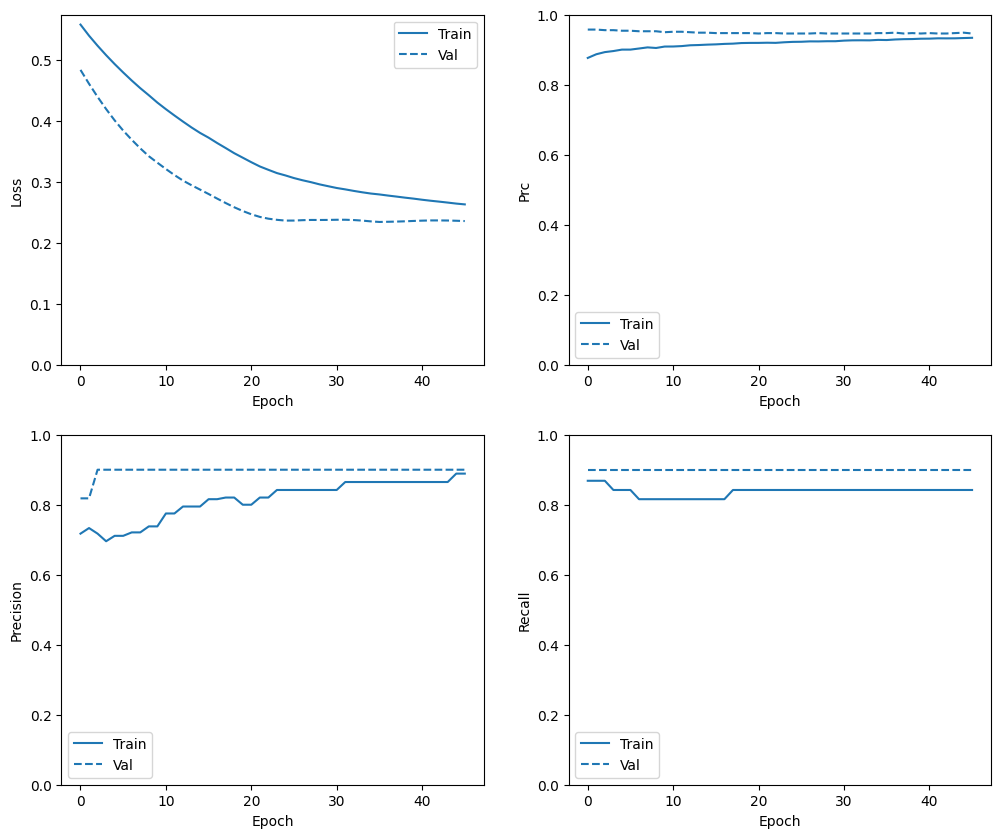

In [29]:
plot_metrics(history)
#plt.show()

In [30]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_min_max.append(value)

1/1 [==============================] - 0s 20ms/step
loss :  0.2017112672328949
tp :  4.0
fp :  0.0
tn :  9.0
fn :  2.0
accuracy :  0.8666666746139526
precision :  1.0
recall :  0.6666666865348816
auc :  1.0
prc :  1.0


True Negatives:  9
False Positives:  0
False Negatives:  2
True Positives:  4
Total:  6


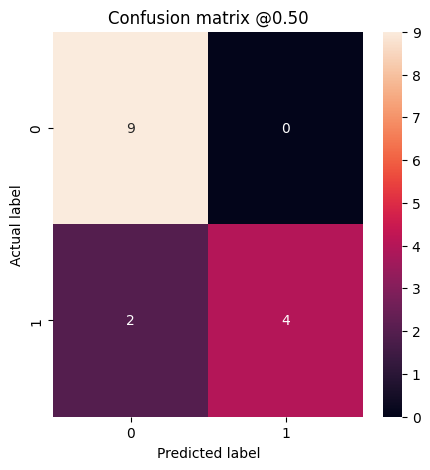

In [31]:
plot_cm(y_test, predictions_test)
#plt.show()

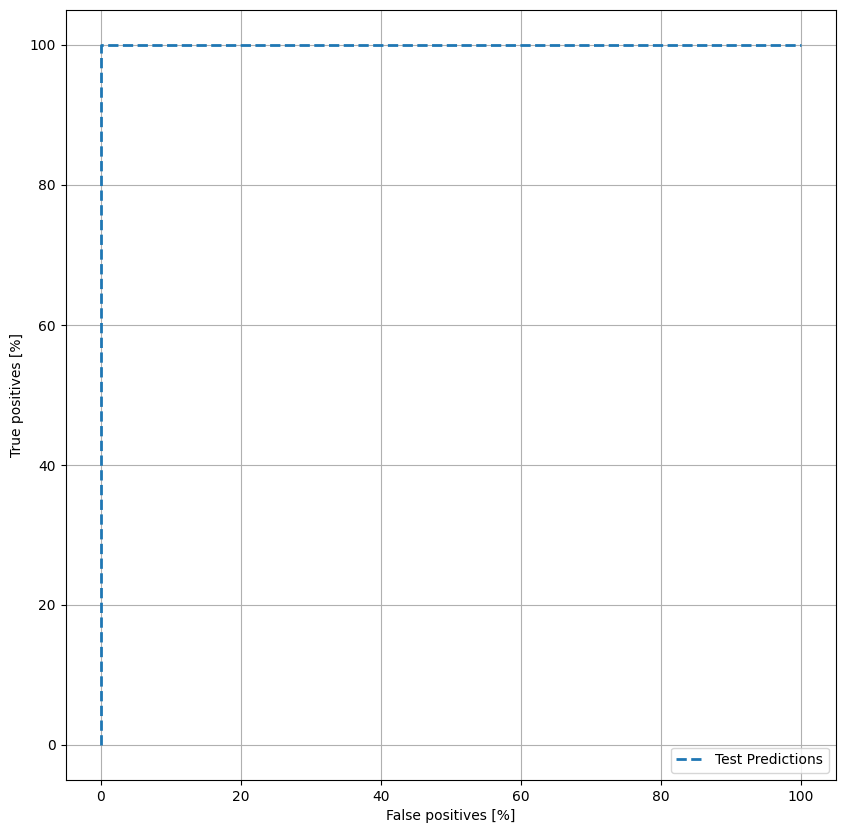

In [32]:
plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [33]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [34]:
#STOP

## 1.2 Dense Model with 32 Lines

### 1.2.1 Load Prepared Dataset

In [35]:
#columns to drop
columns = ['image', 'algo']

df = df_damage_thirtytwo_min_max.drop(columns=columns)

### 1.2.2 Split into sets for training, validation, and testing + use and save scaler

In [36]:
X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### 1.2.3 Experimentation

#### 1.2.3.1 Configurations

In [37]:
EPOCHS = 500
BATCH_SIZE = 50

input_dim = X_train.shape[1]
output_size = 1

units = 16
activation = 'relu'
#activation = 'tanh'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
optimizer = 'Adam'
learning_rate = 1e-3

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

#### 1.2.3.2 Model

In [38]:
model = make_dense_model(metrics=METRICS,
                         layers=LAYERS, 
                         loss='binary_crossentropy',
                         optimizer=optimizer,
                         learning_rate=learning_rate, 
                         input_dim=input_dim)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                592       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_val, y_val), 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    verbose=1,
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping])

Epoch 1/500
3/3 [==============================] - 2s 243ms/step - loss: 0.6324 - tp: 45.0000 - fp: 51.0000 - tn: 19.0000 - fn: 6.0000 - accuracy: 0.5289 - precision: 0.4688 - recall: 0.8824 - auc: 0.8317 - prc: 0.8555 - val_loss: 0.5657 - val_tp: 12.0000 - val_fp: 8.0000 - val_tn: 6.0000 - val_fn: 1.0000 - val_accuracy: 0.6667 - val_precision: 0.6000 - val_recall: 0.9231 - val_auc: 0.8681 - val_prc: 0.9058
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 0.5745 - tp: 40.0000 - fp: 38.0000 - tn: 23.0000 - fn: 5.0000 - accuracy: 0.5943 - precision: 0.5128 - recall: 0.8889 - auc: 0.8845 - prc: 0.9062 - val_loss: 0.5099 - val_tp: 12.0000 - val_fp: 5.0000 - val_tn: 9.0000 - val_fn: 1.0000 - val_accuracy: 0.7778 - val_precision: 0.7059 - val_recall: 0.9231 - val_auc: 0.9011 - val_prc: 0.9239
Epoch 3/500
3/3 [==============================] - 0s 26ms/step - loss: 0.5321 - tp: 40.0000 - fp: 23.0000 - tn: 38.0000 - fn: 5.0000 - accuracy: 0.7358 - precision: 0.6349 - reca

Epoch 21/500
3/3 [==============================] - 0s 26ms/step - loss: 0.3065 - tp: 39.0000 - fp: 8.0000 - tn: 53.0000 - fn: 6.0000 - accuracy: 0.8679 - precision: 0.8298 - recall: 0.8667 - auc: 0.9423 - prc: 0.9466 - val_loss: 0.3800 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 4.0000 - val_accuracy: 0.8148 - val_precision: 0.9000 - val_recall: 0.6923 - val_auc: 0.8681 - val_prc: 0.8949
Epoch 22/500
3/3 [==============================] - 0s 27ms/step - loss: 0.3010 - tp: 39.0000 - fp: 8.0000 - tn: 53.0000 - fn: 6.0000 - accuracy: 0.8679 - precision: 0.8298 - recall: 0.8667 - auc: 0.9443 - prc: 0.9478 - val_loss: 0.3833 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 4.0000 - val_accuracy: 0.8148 - val_precision: 0.9000 - val_recall: 0.6923 - val_auc: 0.8681 - val_prc: 0.8949
Epoch 23/500
3/3 [==============================] - 0s 26ms/step - loss: 0.2966 - tp: 39.0000 - fp: 7.0000 - tn: 54.0000 - fn: 6.0000 - accuracy: 0.8774 - precision: 0.8478 - recal

In [40]:
early_stopping.stopped_epoch

25

In [41]:
#plot_loss(history, "Bias", 0)
#plt.show()

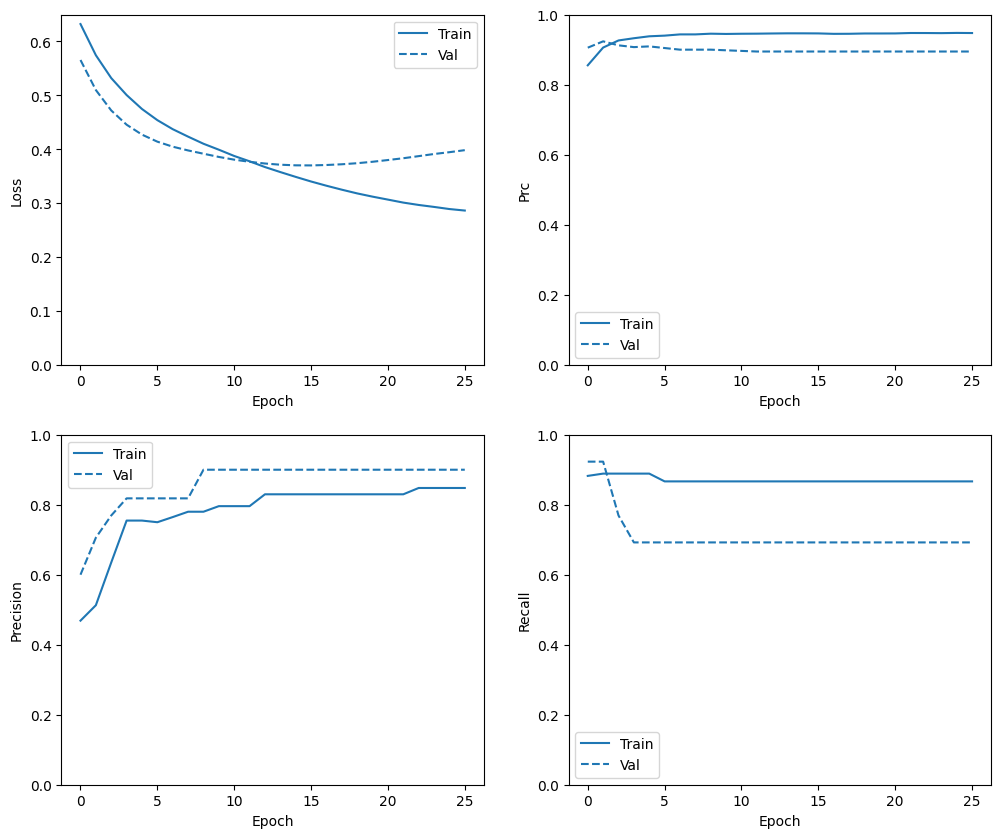

In [42]:
plot_metrics(history)
#plt.show()

In [43]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_min_max.append(value)

1/1 [==============================] - 0s 19ms/step
loss :  0.22507645189762115
tp :  5.0
fp :  0.0
tn :  9.0
fn :  1.0
accuracy :  0.9333333373069763
precision :  1.0
recall :  0.8333333134651184
auc :  1.0
prc :  1.0


True Negatives:  9
False Positives:  0
False Negatives:  1
True Positives:  5
Total:  6


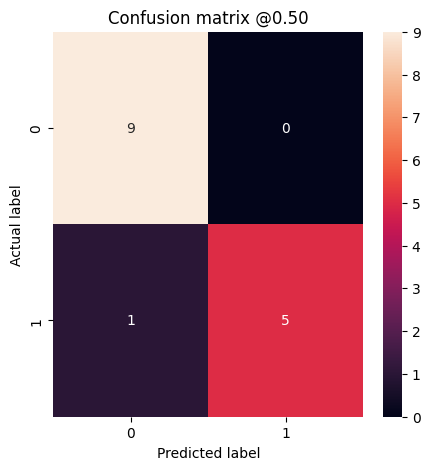

In [44]:
plot_cm(y_test, predictions_test)
#plt.show()

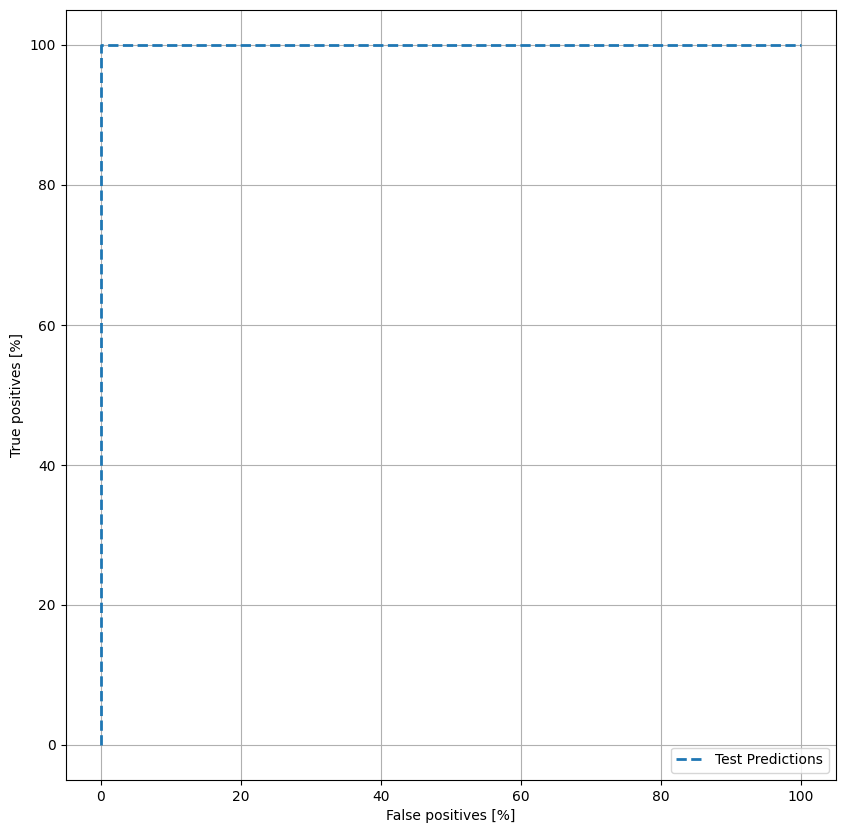

In [45]:
plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [46]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [47]:
#STOP

## 1.3 Dense Model with 16 Lines

### 1.3.1 Load Prepared Dataset

In [48]:
#columns to drop
#columns = ['min', 'max', 'mean', 'orig', 'image', 'algo', 'Image', 'Group']
columns = ['image', 'algo']

df = df_damage_sixteen_mean.drop(columns=columns)

### 1.3.2 Split into sets for training, validation, and testing + use and save scaler

In [49]:
X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### 1.3.3 Experimentation

#### 1.3.3.1 Configurations

In [50]:
EPOCHS = 500
BATCH_SIZE = 50

input_dim = X_train.shape[1]
output_size = 1

units = 16
activation = 'relu'
#activation = 'tanh'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
optimizer = 'Adam'
learning_rate = 1e-3

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

#### 1.3.3.2 Model

In [51]:
model = make_dense_model(metrics=METRICS,
                         layers=LAYERS, 
                         loss='binary_crossentropy',
                         optimizer=optimizer,
                         learning_rate=learning_rate, 
                         input_dim=input_dim)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                336       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_val, y_val), 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    verbose=1,
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping])

Epoch 1/500
3/3 [==============================] - 2s 237ms/step - loss: 0.6869 - tp: 23.0000 - fp: 13.0000 - tn: 54.0000 - fn: 31.0000 - accuracy: 0.6364 - precision: 0.6389 - recall: 0.4259 - auc: 0.6953 - prc: 0.6468 - val_loss: 0.6067 - val_tp: 4.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 6.0000 - val_accuracy: 0.7037 - val_precision: 0.6667 - val_recall: 0.4000 - val_auc: 0.7176 - val_prc: 0.6610
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 0.6780 - tp: 18.0000 - fp: 12.0000 - tn: 46.0000 - fn: 30.0000 - accuracy: 0.6038 - precision: 0.6000 - recall: 0.3750 - auc: 0.6415 - prc: 0.5654 - val_loss: 0.5992 - val_tp: 4.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 6.0000 - val_accuracy: 0.7037 - val_precision: 0.6667 - val_recall: 0.4000 - val_auc: 0.7324 - val_prc: 0.6711
Epoch 3/500
3/3 [==============================] - 0s 33ms/step - loss: 0.6728 - tp: 18.0000 - fp: 12.0000 - tn: 46.0000 - fn: 30.0000 - accuracy: 0.6038 - precision: 0.6000 - r

Epoch 21/500
3/3 [==============================] - 0s 29ms/step - loss: 0.6173 - tp: 27.0000 - fp: 12.0000 - tn: 46.0000 - fn: 21.0000 - accuracy: 0.6887 - precision: 0.6923 - recall: 0.5625 - auc: 0.7408 - prc: 0.6650 - val_loss: 0.5873 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 14.0000 - val_fn: 5.0000 - val_accuracy: 0.7037 - val_precision: 0.6250 - val_recall: 0.5000 - val_auc: 0.7382 - val_prc: 0.6717
Epoch 22/500
3/3 [==============================] - 0s 27ms/step - loss: 0.6160 - tp: 28.0000 - fp: 12.0000 - tn: 46.0000 - fn: 20.0000 - accuracy: 0.6981 - precision: 0.7000 - recall: 0.5833 - auc: 0.7421 - prc: 0.6673 - val_loss: 0.5865 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 14.0000 - val_fn: 5.0000 - val_accuracy: 0.7037 - val_precision: 0.6250 - val_recall: 0.5000 - val_auc: 0.7412 - val_prc: 0.6728
Epoch 23/500
3/3 [==============================] - 0s 26ms/step - loss: 0.6143 - tp: 29.0000 - fp: 12.0000 - tn: 46.0000 - fn: 19.0000 - accuracy: 0.7075 - precision: 0.7073 -

In [53]:
early_stopping.stopped_epoch

26

In [54]:
#plot_loss(history, "Bias", 0)
#plt.show()

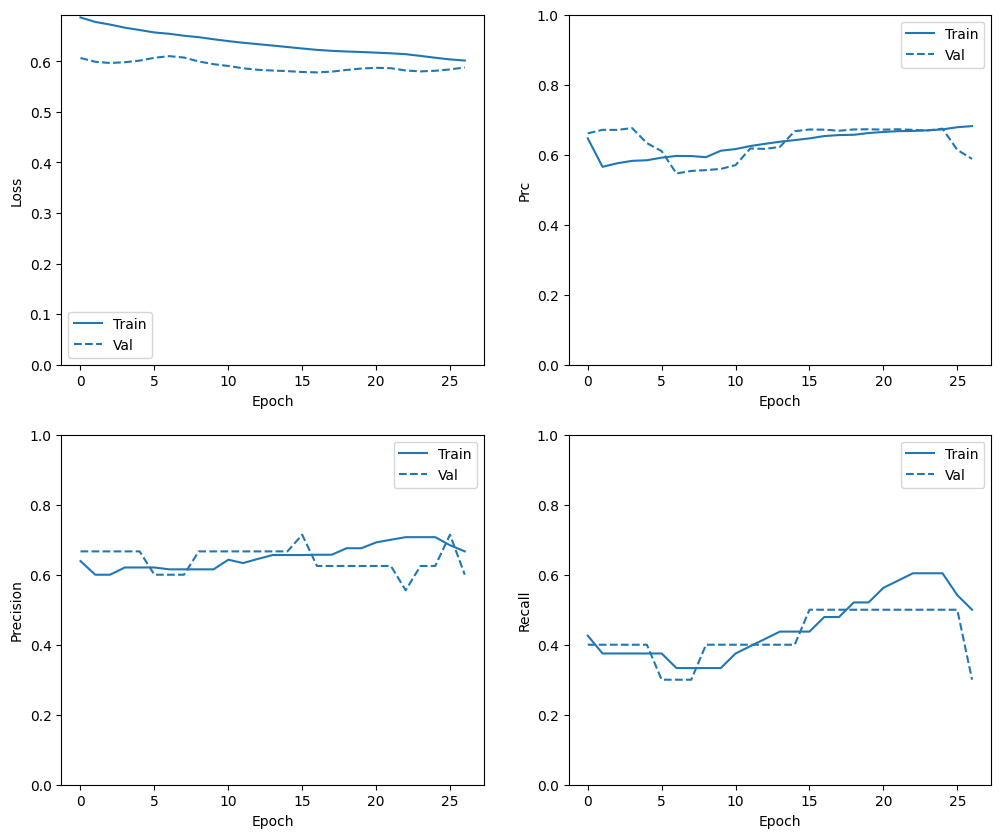

In [55]:
plot_metrics(history)
#plt.show()

In [56]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_mean.append(value)

1/1 [==============================] - 0s 19ms/step
loss :  0.754694402217865
tp :  2.0
fp :  2.0
tn :  5.0
fn :  6.0
accuracy :  0.46666666865348816
precision :  0.5
recall :  0.25
auc :  0.6428571343421936
prc :  0.6429333686828613


True Negatives:  5
False Positives:  2
False Negatives:  6
True Positives:  2
Total:  8


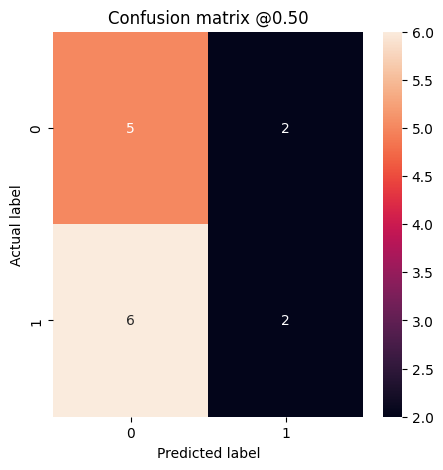

In [57]:
plot_cm(y_test, predictions_test)
#plt.show()

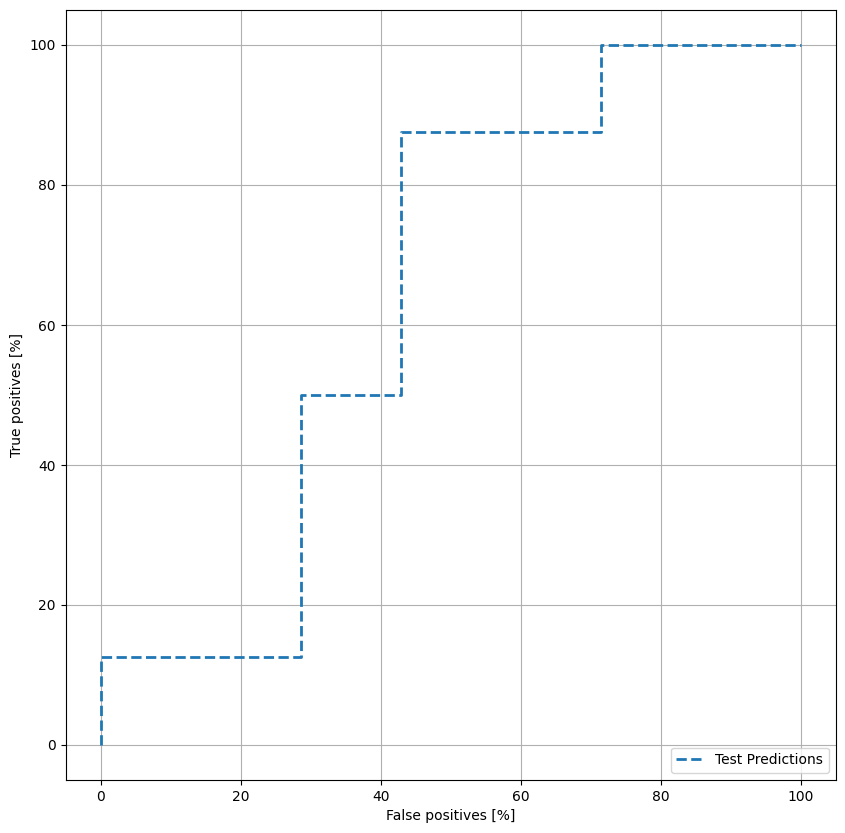

In [58]:
plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [59]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [60]:
#STOP

## 1.4 Dense Model with 32 Lines

### 1.4.1 Load Prepared Dataset

In [61]:
#columns to drop
columns = ['image', 'algo']

df = df_damage_thirtytwo_mean.drop(columns=columns)

### 1.4.2 Split into sets for training, validation, and testing + use and save scaler

In [62]:
X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### 1.4.3 Experimentation

#### 1.4.3.1 Configurations

In [63]:
EPOCHS = 500
BATCH_SIZE = 50

input_dim = X_train.shape[1]
output_size = 1

units = 16
activation = 'relu'
#activation = 'tanh'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
optimizer = 'Adam'
learning_rate = 1e-3

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

#### 1.4.3.2 Model

In [64]:
model = make_dense_model(metrics=METRICS,
                         layers=LAYERS, 
                         loss='binary_crossentropy',
                         optimizer=optimizer,
                         learning_rate=learning_rate, 
                         input_dim=input_dim)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                592       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_val, y_val), 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    verbose=1,
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping])

Epoch 1/500
3/3 [==============================] - 2s 238ms/step - loss: 0.6980 - tp: 13.0000 - fp: 10.0000 - tn: 54.0000 - fn: 44.0000 - accuracy: 0.5537 - precision: 0.5652 - recall: 0.2281 - auc: 0.5296 - prc: 0.4971 - val_loss: 0.7008 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 15.0000 - val_fn: 11.0000 - val_accuracy: 0.5556 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4318 - val_prc: 0.3494
Epoch 2/500
3/3 [==============================] - 0s 28ms/step - loss: 0.6820 - tp: 10.0000 - fp: 10.0000 - tn: 47.0000 - fn: 39.0000 - accuracy: 0.5377 - precision: 0.5000 - recall: 0.2041 - auc: 0.5854 - prc: 0.5432 - val_loss: 0.6737 - val_tp: 2.0000 - val_fp: 2.0000 - val_tn: 14.0000 - val_fn: 9.0000 - val_accuracy: 0.5926 - val_precision: 0.5000 - val_recall: 0.1818 - val_auc: 0.5227 - val_prc: 0.4290
Epoch 3/500
3/3 [==============================] - 0s 28ms/step - loss: 0.6691 - tp: 13.0000 - fp: 10.0000 - tn: 47.0000 - fn: 36.0000 - accuracy: 0.5660 - precisio

Epoch 21/500
3/3 [==============================] - 0s 27ms/step - loss: 0.6185 - tp: 23.0000 - fp: 12.0000 - tn: 45.0000 - fn: 26.0000 - accuracy: 0.6415 - precision: 0.6571 - recall: 0.4694 - auc: 0.7225 - prc: 0.7025 - val_loss: 0.6436 - val_tp: 3.0000 - val_fp: 4.0000 - val_tn: 12.0000 - val_fn: 8.0000 - val_accuracy: 0.5556 - val_precision: 0.4286 - val_recall: 0.2727 - val_auc: 0.6222 - val_prc: 0.5402
Epoch 22/500
3/3 [==============================] - 0s 29ms/step - loss: 0.6173 - tp: 24.0000 - fp: 12.0000 - tn: 45.0000 - fn: 25.0000 - accuracy: 0.6509 - precision: 0.6667 - recall: 0.4898 - auc: 0.7284 - prc: 0.7138 - val_loss: 0.6526 - val_tp: 3.0000 - val_fp: 4.0000 - val_tn: 12.0000 - val_fn: 8.0000 - val_accuracy: 0.5556 - val_precision: 0.4286 - val_recall: 0.2727 - val_auc: 0.5938 - val_prc: 0.5281
Epoch 22: early stopping


In [66]:
early_stopping.stopped_epoch

21

In [67]:
#plot_loss(history, "Bias", 0)
#plt.show()

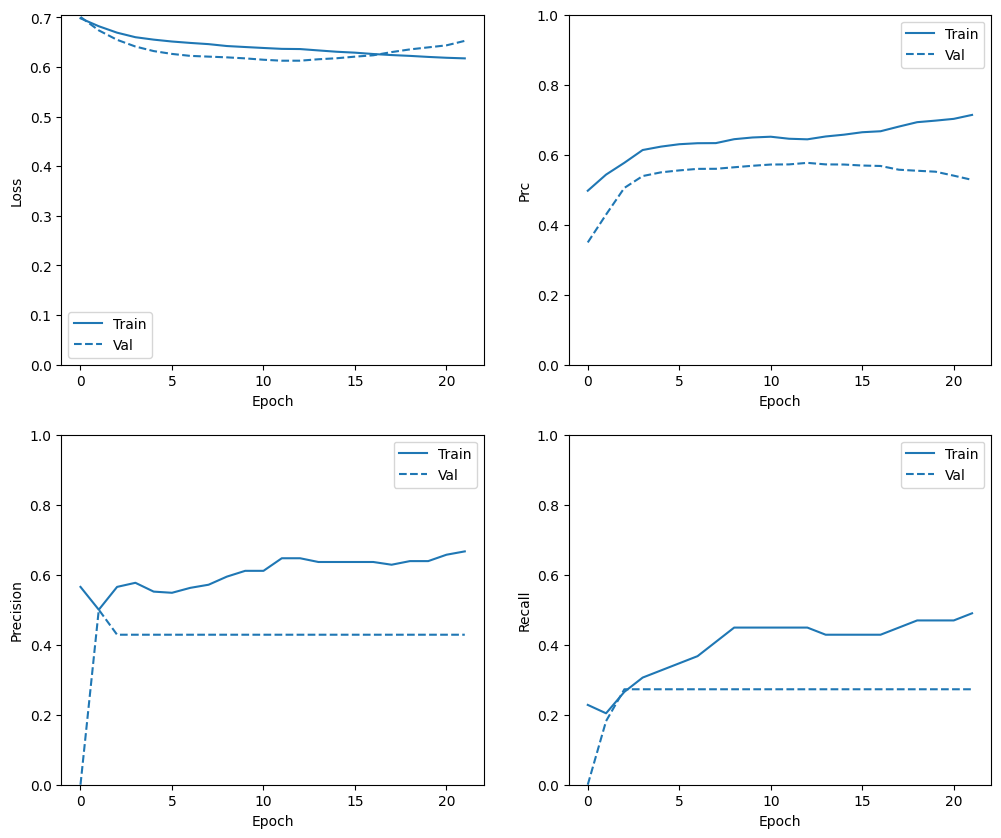

In [68]:
plot_metrics(history)
#plt.show()

In [69]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_mean.append(value)

1/1 [==============================] - 0s 20ms/step
loss :  0.7334400415420532
tp :  1.0
fp :  1.0
tn :  6.0
fn :  7.0
accuracy :  0.46666666865348816
precision :  0.5
recall :  0.125
auc :  0.5535714030265808
prc :  0.5911433100700378


True Negatives:  6
False Positives:  1
False Negatives:  7
True Positives:  1
Total:  8


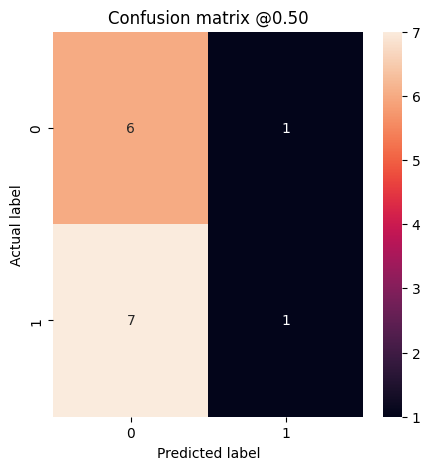

In [70]:
plot_cm(y_test, predictions_test)
#plt.show()

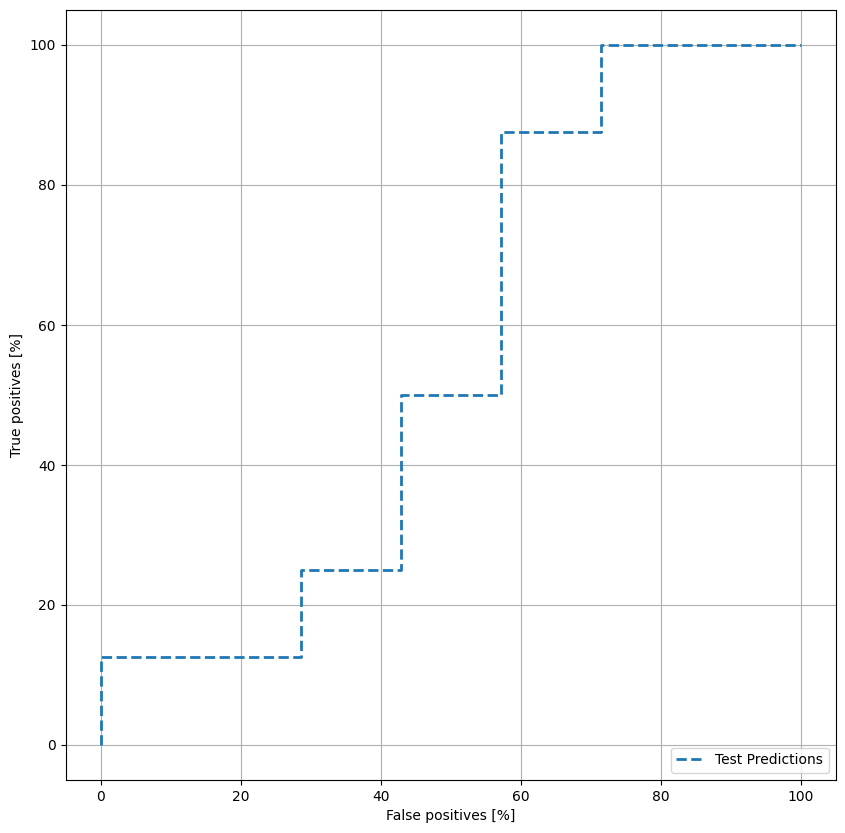

In [71]:
plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [72]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [73]:
#STOP

# 2 CNN Model

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, MaxPooling1D, Dropout, Flatten
from keras.layers import BatchNormalization

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_cnn_model(loss, optimizer, learning_rate, metrics, in_shape, kernel_size, kernel_initializer, pool_size, filters_1, filters_2, filters_3, filters_4):
    
    model = Sequential()
    model.add(Conv1D(filters= filters_1, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer, input_shape=in_shape))
    
    model.add(Conv1D(filters= filters_2, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer))
    model.add(MaxPool1D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    #model.add(Conv1D(filters= filters_3, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer))
    #model.add(MaxPool1D(pool_size=pool_size))
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    #model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    model.add(Dense(n_classes, activation=output_activation))
    
    
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

## 2.1 CNN Model with 16 Lines

### 2.1.1 Load Prepared Dataset

In [75]:
#columns to drop
columns = ['image', 'algo']

df = df_damage_sixteen_min_max.drop(columns=columns)

### 2.1.2 Split into sets for training, validation, and testing + use and save scaler

In [76]:
X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### 2.1.3 Experimentation

#### 2.1.3.1 Configurations

In [77]:
from numpy import unique
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))



EPOCHS = 500
BATCH_SIZE = 2050

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

units = 64
activation = 'relu'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
#output_activation = 'softmax'
optimizer = 'Adam'
learning_rate = 1e-3
filters_1 = 8
filters_2 = 16
filters_3 = 32
filters_4 = 12
kernel_size = 3
pool_size = 2
strides = 1

Before: (20,)
After: (20, 1)
Classes: 1


#### 2.1.3.2 Model

In [78]:
model = make_cnn_model(metrics=METRICS, 
                       loss='binary_crossentropy', 
                       optimizer=optimizer, 
                       learning_rate=learning_rate,
                       in_shape= in_shape,
                       kernel_size=kernel_size,
                       kernel_initializer=kernel_initializer,
                       pool_size=pool_size,
                       filters_1=filters_1,
                       filters_2=filters_2,
                       filters_3=filters_3,
                       filters_4=filters_4)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 8)             32        
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            400       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 16)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 16)             0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 8)                 1032      
                                                      

In [79]:
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_val, y_val), 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    verbose=1,
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping])

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 1.2623 - tp: 2.0000 - fp: 46.0000 - tn: 22.0000 - fn: 36.0000 - accuracy: 0.2264 - precision: 0.0417 - recall: 0.0526 - auc: 0.1004 - prc: 0.2142 - val_loss: 1.1232 - val_tp: 1.0000 - val_fp: 13.0000 - val_tn: 4.0000 - val_fn: 9.0000 - val_accuracy: 0.1852 - val_precision: 0.0714 - val_recall: 0.1000 - val_auc: 0.0647 - val_prc: 0.2189
Epoch 2/500
1/1 [==============================] - 0s 60ms/step - loss: 1.1002 - tp: 6.0000 - fp: 39.0000 - tn: 29.0000 - fn: 32.0000 - accuracy: 0.3302 - precision: 0.1333 - recall: 0.1579 - auc: 0.1786 - prc: 0.2523 - val_loss: 1.0505 - val_tp: 0.0000e+00 - val_fp: 12.0000 - val_tn: 5.0000 - val_fn: 10.0000 - val_accuracy: 0.1852 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0618 - val_prc: 0.2191
Epoch 3/500
1/1 [==============================] - 0s 59ms/step - loss: 1.2107 - tp: 7.0000 - fp: 47.0000 - tn: 21.0000 - fn: 31.0000 - accuracy: 0.2642 - precision: 0.1

1/1 [==============================] - 0s 70ms/step - loss: 0.6680 - tp: 11.0000 - fp: 15.0000 - tn: 53.0000 - fn: 27.0000 - accuracy: 0.6038 - precision: 0.4231 - recall: 0.2895 - auc: 0.5908 - prc: 0.4472 - val_loss: 0.6298 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 8.0000 - val_accuracy: 0.7037 - val_precision: 1.0000 - val_recall: 0.2000 - val_auc: 0.8118 - val_prc: 0.7421
Epoch 21/500
1/1 [==============================] - 0s 58ms/step - loss: 0.7054 - tp: 6.0000 - fp: 12.0000 - tn: 56.0000 - fn: 32.0000 - accuracy: 0.5849 - precision: 0.3333 - recall: 0.1579 - auc: 0.5000 - prc: 0.3706 - val_loss: 0.6239 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 8.0000 - val_accuracy: 0.7037 - val_precision: 1.0000 - val_recall: 0.2000 - val_auc: 0.8382 - val_prc: 0.7834
Epoch 22/500
1/1 [==============================] - 0s 57ms/step - loss: 0.7034 - tp: 9.0000 - fp: 15.0000 - tn: 53.0000 - fn: 29.0000 - accuracy: 0.5849 - precision: 0.3750 - recall

Epoch 40/500
1/1 [==============================] - 0s 53ms/step - loss: 0.5453 - tp: 14.0000 - fp: 4.0000 - tn: 64.0000 - fn: 24.0000 - accuracy: 0.7358 - precision: 0.7778 - recall: 0.3684 - auc: 0.8090 - prc: 0.6760 - val_loss: 0.4616 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 2.0000 - val_accuracy: 0.8889 - val_precision: 0.8889 - val_recall: 0.8000 - val_auc: 0.9000 - val_prc: 0.8911
Epoch 41/500
1/1 [==============================] - 0s 52ms/step - loss: 0.5261 - tp: 17.0000 - fp: 4.0000 - tn: 64.0000 - fn: 21.0000 - accuracy: 0.7642 - precision: 0.8095 - recall: 0.4474 - auc: 0.8181 - prc: 0.7641 - val_loss: 0.4557 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 2.0000 - val_accuracy: 0.8889 - val_precision: 0.8889 - val_recall: 0.8000 - val_auc: 0.8971 - val_prc: 0.8817
Epoch 42/500
1/1 [==============================] - 0s 53ms/step - loss: 0.5361 - tp: 21.0000 - fp: 5.0000 - tn: 63.0000 - fn: 17.0000 - accuracy: 0.7925 - precision: 0.8077 - re

Epoch 60/500
1/1 [==============================] - 0s 52ms/step - loss: 0.3713 - tp: 26.0000 - fp: 3.0000 - tn: 65.0000 - fn: 12.0000 - accuracy: 0.8585 - precision: 0.8966 - recall: 0.6842 - auc: 0.9296 - prc: 0.8958 - val_loss: 0.3690 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 2.0000 - val_accuracy: 0.8889 - val_precision: 0.8889 - val_recall: 0.8000 - val_auc: 0.9088 - val_prc: 0.9075
Epoch 61/500
1/1 [==============================] - 0s 54ms/step - loss: 0.3579 - tp: 30.0000 - fp: 6.0000 - tn: 62.0000 - fn: 8.0000 - accuracy: 0.8679 - precision: 0.8333 - recall: 0.7895 - auc: 0.9249 - prc: 0.8957 - val_loss: 0.3649 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 2.0000 - val_accuracy: 0.8889 - val_precision: 0.8889 - val_recall: 0.8000 - val_auc: 0.9118 - val_prc: 0.9085
Epoch 62/500
1/1 [==============================] - 0s 56ms/step - loss: 0.4461 - tp: 28.0000 - fp: 8.0000 - tn: 60.0000 - fn: 10.0000 - accuracy: 0.8302 - precision: 0.7778 - rec

Epoch 80/500
1/1 [==============================] - 0s 54ms/step - loss: 0.3045 - tp: 33.0000 - fp: 9.0000 - tn: 59.0000 - fn: 5.0000 - accuracy: 0.8679 - precision: 0.7857 - recall: 0.8684 - auc: 0.9402 - prc: 0.9152 - val_loss: 0.3115 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9265 - val_prc: 0.9347
Epoch 81/500
1/1 [==============================] - 0s 51ms/step - loss: 0.3663 - tp: 31.0000 - fp: 12.0000 - tn: 56.0000 - fn: 7.0000 - accuracy: 0.8208 - precision: 0.7209 - recall: 0.8158 - auc: 0.9133 - prc: 0.8897 - val_loss: 0.3104 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9265 - val_prc: 0.9347
Epoch 82/500
1/1 [==============================] - 0s 53ms/step - loss: 0.3256 - tp: 32.0000 - fp: 11.0000 - tn: 57.0000 - fn: 6.0000 - accuracy: 0.8396 - precision: 0.7442 - rec

Epoch 100/500
1/1 [==============================] - 0s 49ms/step - loss: 0.2665 - tp: 34.0000 - fp: 7.0000 - tn: 61.0000 - fn: 4.0000 - accuracy: 0.8962 - precision: 0.8293 - recall: 0.8947 - auc: 0.9567 - prc: 0.9326 - val_loss: 0.3030 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9235 - val_prc: 0.9337
Epoch 101/500
1/1 [==============================] - 0s 53ms/step - loss: 0.3257 - tp: 32.0000 - fp: 8.0000 - tn: 60.0000 - fn: 6.0000 - accuracy: 0.8679 - precision: 0.8000 - recall: 0.8421 - auc: 0.9265 - prc: 0.9046 - val_loss: 0.3029 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9235 - val_prc: 0.9337
Epoch 102/500
1/1 [==============================] - 0s 53ms/step - loss: 0.2813 - tp: 34.0000 - fp: 8.0000 - tn: 60.0000 - fn: 4.0000 - accuracy: 0.8868 - precision: 0.8095 - re

Epoch 120/500
1/1 [==============================] - 0s 54ms/step - loss: 0.2763 - tp: 33.0000 - fp: 8.0000 - tn: 60.0000 - fn: 5.0000 - accuracy: 0.8774 - precision: 0.8049 - recall: 0.8684 - auc: 0.9472 - prc: 0.9372 - val_loss: 0.2990 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9235 - val_prc: 0.9337
Epoch 121/500
1/1 [==============================] - 0s 52ms/step - loss: 0.3138 - tp: 33.0000 - fp: 7.0000 - tn: 61.0000 - fn: 5.0000 - accuracy: 0.8868 - precision: 0.8250 - recall: 0.8684 - auc: 0.9276 - prc: 0.9197 - val_loss: 0.2987 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9235 - val_prc: 0.9337
Epoch 122/500
1/1 [==============================] - 0s 53ms/step - loss: 0.3055 - tp: 33.0000 - fp: 8.0000 - tn: 60.0000 - fn: 5.0000 - accuracy: 0.8774 - precision: 0.8049 - re

Epoch 140/500
1/1 [==============================] - 0s 51ms/step - loss: 0.2608 - tp: 34.0000 - fp: 6.0000 - tn: 62.0000 - fn: 4.0000 - accuracy: 0.9057 - precision: 0.8500 - recall: 0.8947 - auc: 0.9509 - prc: 0.9386 - val_loss: 0.2885 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9206 - val_prc: 0.9326
Epoch 141/500
1/1 [==============================] - 0s 54ms/step - loss: 0.2536 - tp: 34.0000 - fp: 7.0000 - tn: 61.0000 - fn: 4.0000 - accuracy: 0.8962 - precision: 0.8293 - recall: 0.8947 - auc: 0.9580 - prc: 0.9404 - val_loss: 0.2879 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9206 - val_prc: 0.9326
Epoch 142/500
1/1 [==============================] - 0s 51ms/step - loss: 0.2366 - tp: 33.0000 - fp: 6.0000 - tn: 62.0000 - fn: 5.0000 - accuracy: 0.8962 - precision: 0.8462 - re

Epoch 160/500
1/1 [==============================] - 0s 52ms/step - loss: 0.2265 - tp: 34.0000 - fp: 8.0000 - tn: 60.0000 - fn: 4.0000 - accuracy: 0.8868 - precision: 0.8095 - recall: 0.8947 - auc: 0.9690 - prc: 0.9546 - val_loss: 0.2838 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9206 - val_prc: 0.9326
Epoch 161/500
1/1 [==============================] - 0s 53ms/step - loss: 0.2553 - tp: 31.0000 - fp: 7.0000 - tn: 61.0000 - fn: 7.0000 - accuracy: 0.8679 - precision: 0.8158 - recall: 0.8158 - auc: 0.9555 - prc: 0.9372 - val_loss: 0.2838 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9206 - val_prc: 0.9326
Epoch 162/500
1/1 [==============================] - 0s 51ms/step - loss: 0.2386 - tp: 32.0000 - fp: 5.0000 - tn: 63.0000 - fn: 6.0000 - accuracy: 0.8962 - precision: 0.8649 - re

Epoch 180/500
1/1 [==============================] - 0s 50ms/step - loss: 0.2651 - tp: 33.0000 - fp: 9.0000 - tn: 59.0000 - fn: 5.0000 - accuracy: 0.8679 - precision: 0.7857 - recall: 0.8684 - auc: 0.9520 - prc: 0.9360 - val_loss: 0.2829 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9235 - val_prc: 0.9336
Epoch 181/500
1/1 [==============================] - 0s 50ms/step - loss: 0.2122 - tp: 34.0000 - fp: 6.0000 - tn: 62.0000 - fn: 4.0000 - accuracy: 0.9057 - precision: 0.8500 - recall: 0.8947 - auc: 0.9752 - prc: 0.9581 - val_loss: 0.2832 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9235 - val_prc: 0.9336
Epoch 182/500
1/1 [==============================] - 0s 53ms/step - loss: 0.2163 - tp: 34.0000 - fp: 9.0000 - tn: 59.0000 - fn: 4.0000 - accuracy: 0.8774 - precision: 0.7907 - re

In [80]:
early_stopping.stopped_epoch

182

In [81]:
#plot_loss(history, "Bias", 0)
#plt.show()

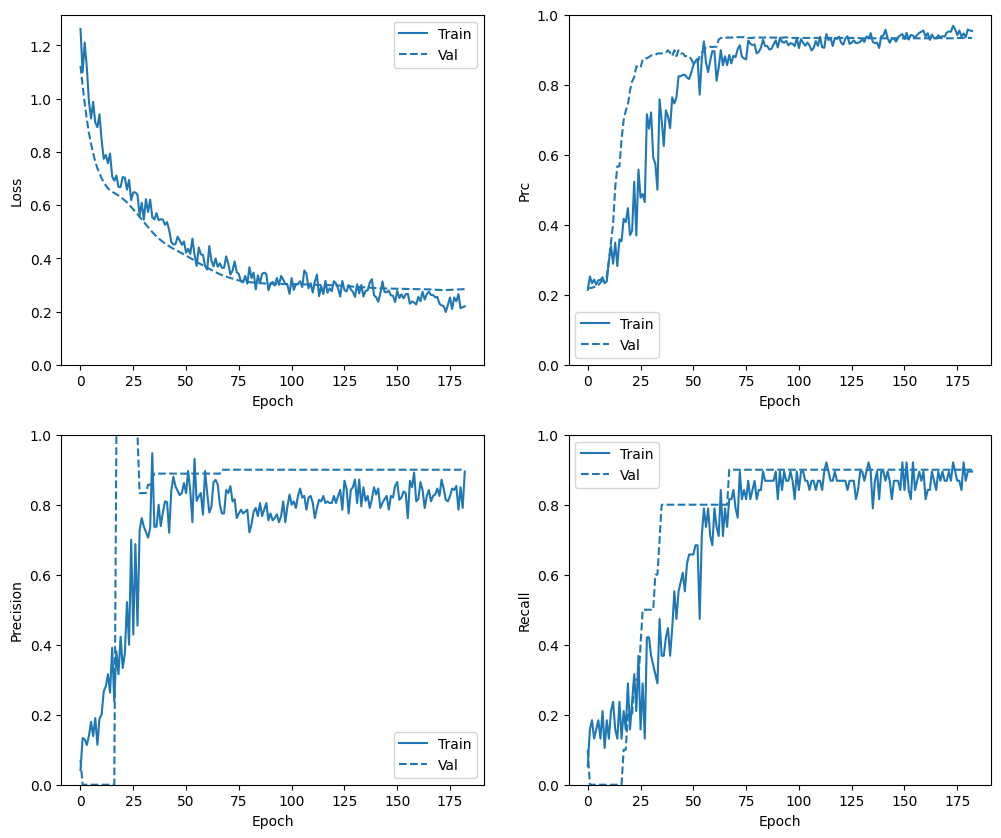

In [82]:
plot_metrics(history)
#plt.show()

In [83]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_min_max.append(value)

1/1 [==============================] - 0s 20ms/step
loss :  0.21638742089271545
tp :  5.0
fp :  0.0
tn :  9.0
fn :  1.0
accuracy :  0.9333333373069763
precision :  1.0
recall :  0.8333333134651184
auc :  0.9814814329147339
prc :  0.9743082523345947


True Negatives:  9
False Positives:  0
False Negatives:  1
True Positives:  5
Total:  6


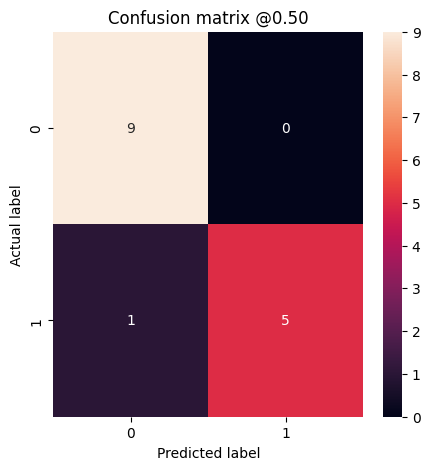

In [84]:
plot_cm(y_test, predictions_test)
#plt.show()

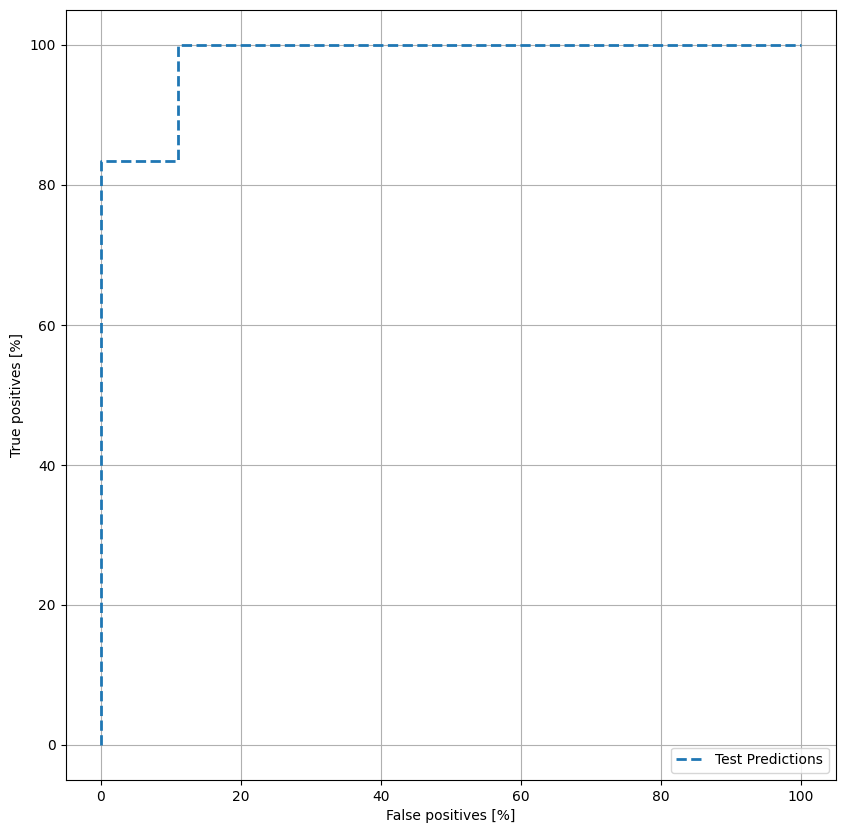

In [85]:
plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [86]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [87]:
#STOP

## 2.2 CNN Model with 32 Lines

### 2.2.1 Load Prepared Dataset

In [88]:
#columns to drop
columns = ['image', 'algo']

df = df_damage_thirtytwo_min_max.drop(columns=columns)

### 2.2.2 Split into sets for training, validation, and testing + use and save scaler

In [89]:
X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### 2.2.3 Experimentation

#### 2.2.3.1 Configurations

In [90]:
from numpy import unique
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))



EPOCHS = 500
BATCH_SIZE = 2050

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

units = 64
activation = 'relu'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
#output_activation = 'softmax'
optimizer = 'Adam'
learning_rate = 1e-3
filters_1 = 8
filters_2 = 16
filters_3 = 32
filters_4 = 12
kernel_size = 3
pool_size = 2
strides = 1

Before: (36,)
After: (36, 1)
Classes: 1


#### 2.2.3.2 Model

In [91]:
model = make_cnn_model(metrics=METRICS, 
                       loss='binary_crossentropy', 
                       optimizer=optimizer, 
                       learning_rate=learning_rate,
                       in_shape= in_shape,
                       kernel_size=kernel_size,
                       kernel_initializer=kernel_initializer,
                       pool_size=pool_size,
                       filters_1=filters_1,
                       filters_2=filters_2,
                       filters_3=filters_3,
                       filters_4=filters_4)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 34, 8)             32        
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 16)            400       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16)            0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 8)                 2056      
                                                      

In [92]:
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_val, y_val), 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    verbose=1,
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping])

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.9253 - tp: 7.0000 - fp: 4.0000 - tn: 66.0000 - fn: 44.0000 - accuracy: 0.6033 - precision: 0.6364 - recall: 0.1373 - auc: 0.4895 - prc: 0.4968 - val_loss: 0.6974 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 12.0000 - val_accuracy: 0.5185 - val_precision: 0.5000 - val_recall: 0.0769 - val_auc: 0.6126 - val_prc: 0.5295
Epoch 2/500
1/1 [==============================] - 0s 59ms/step - loss: 1.1040 - tp: 4.0000 - fp: 7.0000 - tn: 54.0000 - fn: 41.0000 - accuracy: 0.5472 - precision: 0.3636 - recall: 0.0889 - auc: 0.3566 - prc: 0.3667 - val_loss: 0.6641 - val_tp: 4.0000 - val_fp: 2.0000 - val_tn: 12.0000 - val_fn: 9.0000 - val_accuracy: 0.5926 - val_precision: 0.6667 - val_recall: 0.3077 - val_auc: 0.6676 - val_prc: 0.5983
Epoch 3/500
1/1 [==============================] - 0s 59ms/step - loss: 0.8676 - tp: 7.0000 - fp: 8.0000 - tn: 53.0000 - fn: 38.0000 - accuracy: 0.5660 - precision: 0.4667 - recall: 0

Epoch 21/500
1/1 [==============================] - 0s 61ms/step - loss: 0.4276 - tp: 33.0000 - fp: 7.0000 - tn: 54.0000 - fn: 12.0000 - accuracy: 0.8208 - precision: 0.8250 - recall: 0.7333 - auc: 0.8872 - prc: 0.8892 - val_loss: 0.4684 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 12.0000 - val_fn: 4.0000 - val_accuracy: 0.7778 - val_precision: 0.8182 - val_recall: 0.6923 - val_auc: 0.8681 - val_prc: 0.8887
Epoch 22/500
1/1 [==============================] - 0s 62ms/step - loss: 0.3773 - tp: 36.0000 - fp: 5.0000 - tn: 56.0000 - fn: 9.0000 - accuracy: 0.8679 - precision: 0.8780 - recall: 0.8000 - auc: 0.9220 - prc: 0.9324 - val_loss: 0.4633 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 12.0000 - val_fn: 4.0000 - val_accuracy: 0.7778 - val_precision: 0.8182 - val_recall: 0.6923 - val_auc: 0.8681 - val_prc: 0.8887
Epoch 23/500
1/1 [==============================] - 0s 55ms/step - loss: 0.3751 - tp: 34.0000 - fp: 6.0000 - tn: 55.0000 - fn: 11.0000 - accuracy: 0.8396 - precision: 0.8500 - rec

In [93]:
early_stopping.stopped_epoch

34

In [94]:
#plot_loss(history, "Bias", 0)
#plt.show()

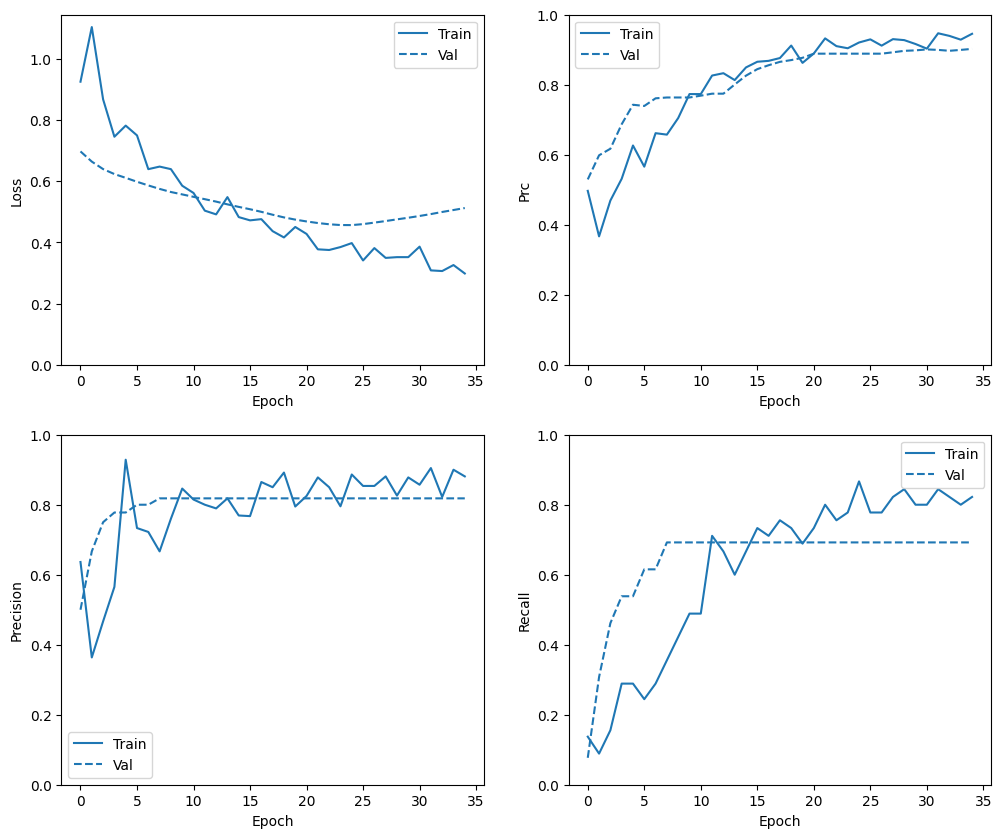

In [95]:
plot_metrics(history)
#plt.show()

In [96]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_min_max.append(value)

1/1 [==============================] - 0s 20ms/step
loss :  0.18960167467594147
tp :  5.0
fp :  0.0
tn :  9.0
fn :  1.0
accuracy :  0.9333333373069763
precision :  1.0
recall :  0.8333333134651184
auc :  1.0
prc :  1.0


True Negatives:  9
False Positives:  0
False Negatives:  1
True Positives:  5
Total:  6


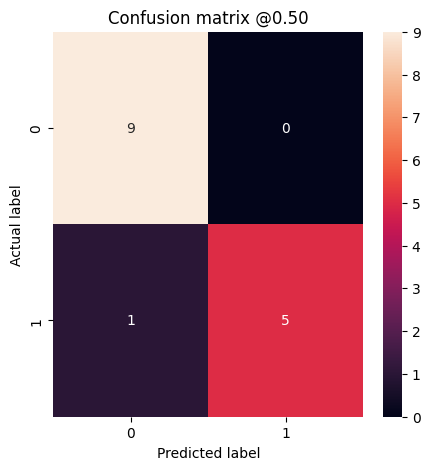

In [97]:
plot_cm(y_test, predictions_test)
#plt.show()

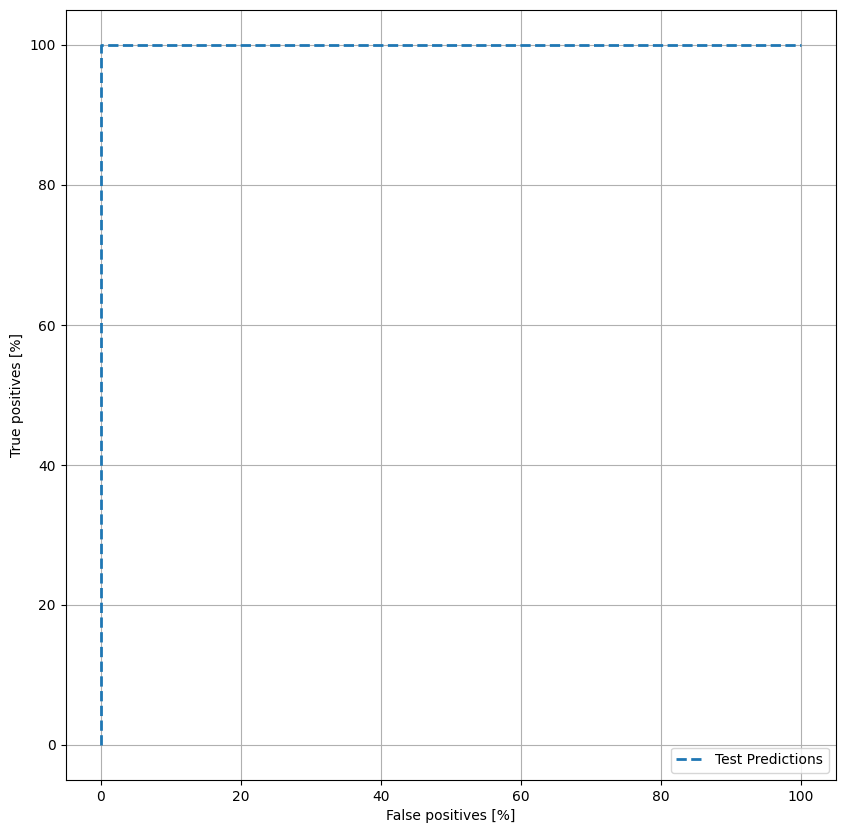

In [98]:
plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [99]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [100]:
#STOP

## 2.3 CNN Model with 16 Lines

### 2.3.1 Load Prepared Dataset

In [101]:
#columns to drop
columns = ['image', 'algo']

df = df_damage_sixteen_mean.drop(columns=columns)

### 2.3.2 Split into sets for training, validation, and testing + use and save scaler

In [102]:
X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### 2.3.3 Experimentation

#### 2.3.3.1 Configurations

In [103]:
from numpy import unique
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))



EPOCHS = 500
BATCH_SIZE = 2050

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

units = 64
activation = 'relu'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
#output_activation = 'softmax'
optimizer = 'Adam'
learning_rate = 1e-3
filters_1 = 8
filters_2 = 16
filters_3 = 32
filters_4 = 12
kernel_size = 3
pool_size = 2
strides = 1

Before: (20,)
After: (20, 1)
Classes: 1


#### 2.3.3.2 Model

In [104]:
model = make_cnn_model(metrics=METRICS, 
                       loss='binary_crossentropy', 
                       optimizer=optimizer, 
                       learning_rate=learning_rate,
                       in_shape= in_shape,
                       kernel_size=kernel_size,
                       kernel_initializer=kernel_initializer,
                       pool_size=pool_size,
                       filters_1=filters_1,
                       filters_2=filters_2,
                       filters_3=filters_3,
                       filters_4=filters_4)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 18, 8)             32        
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 16)            400       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 16)            0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 8, 16)             0         
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 8)                 1032      
                                                      

In [105]:
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_val, y_val), 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    verbose=1,
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping])

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.7532 - tp: 25.0000 - fp: 18.0000 - tn: 49.0000 - fn: 29.0000 - accuracy: 0.6116 - precision: 0.5814 - recall: 0.4630 - auc: 0.6548 - prc: 0.5629 - val_loss: 0.6053 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 7.0000 - val_accuracy: 0.7407 - val_precision: 1.0000 - val_recall: 0.3000 - val_auc: 0.7235 - val_prc: 0.7230
Epoch 2/500
1/1 [==============================] - 0s 60ms/step - loss: 0.7802 - tp: 20.0000 - fp: 22.0000 - tn: 36.0000 - fn: 28.0000 - accuracy: 0.5283 - precision: 0.4762 - recall: 0.4167 - auc: 0.5390 - prc: 0.4795 - val_loss: 0.6001 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 17.0000 - val_fn: 6.0000 - val_accuracy: 0.7778 - val_precision: 1.0000 - val_recall: 0.4000 - val_auc: 0.7265 - val_prc: 0.7145
Epoch 3/500
1/1 [==============================] - 0s 55ms/step - loss: 0.8052 - tp: 20.0000 - fp: 24.0000 - tn: 34.0000 - fn: 28.0000 - accuracy: 0.5094 - precision: 0.454

Epoch 21/500
1/1 [==============================] - 0s 56ms/step - loss: 0.6428 - tp: 18.0000 - fp: 15.0000 - tn: 43.0000 - fn: 30.0000 - accuracy: 0.5755 - precision: 0.5455 - recall: 0.3750 - auc: 0.6604 - prc: 0.6354 - val_loss: 0.5777 - val_tp: 4.0000 - val_fp: 4.0000 - val_tn: 13.0000 - val_fn: 6.0000 - val_accuracy: 0.6296 - val_precision: 0.5000 - val_recall: 0.4000 - val_auc: 0.7088 - val_prc: 0.6535
Epoch 22/500
1/1 [==============================] - 0s 60ms/step - loss: 0.6921 - tp: 23.0000 - fp: 14.0000 - tn: 44.0000 - fn: 25.0000 - accuracy: 0.6321 - precision: 0.6216 - recall: 0.4792 - auc: 0.6189 - prc: 0.6019 - val_loss: 0.5778 - val_tp: 4.0000 - val_fp: 3.0000 - val_tn: 14.0000 - val_fn: 6.0000 - val_accuracy: 0.6667 - val_precision: 0.5714 - val_recall: 0.4000 - val_auc: 0.7088 - val_prc: 0.6589
Epoch 23/500
1/1 [==============================] - 0s 52ms/step - loss: 0.6525 - tp: 26.0000 - fp: 13.0000 - tn: 45.0000 - fn: 22.0000 - accuracy: 0.6698 - precision: 0.6667 -

In [106]:
early_stopping.stopped_epoch

26

In [107]:
#plot_loss(history, "Bias", 0)
#plt.show()

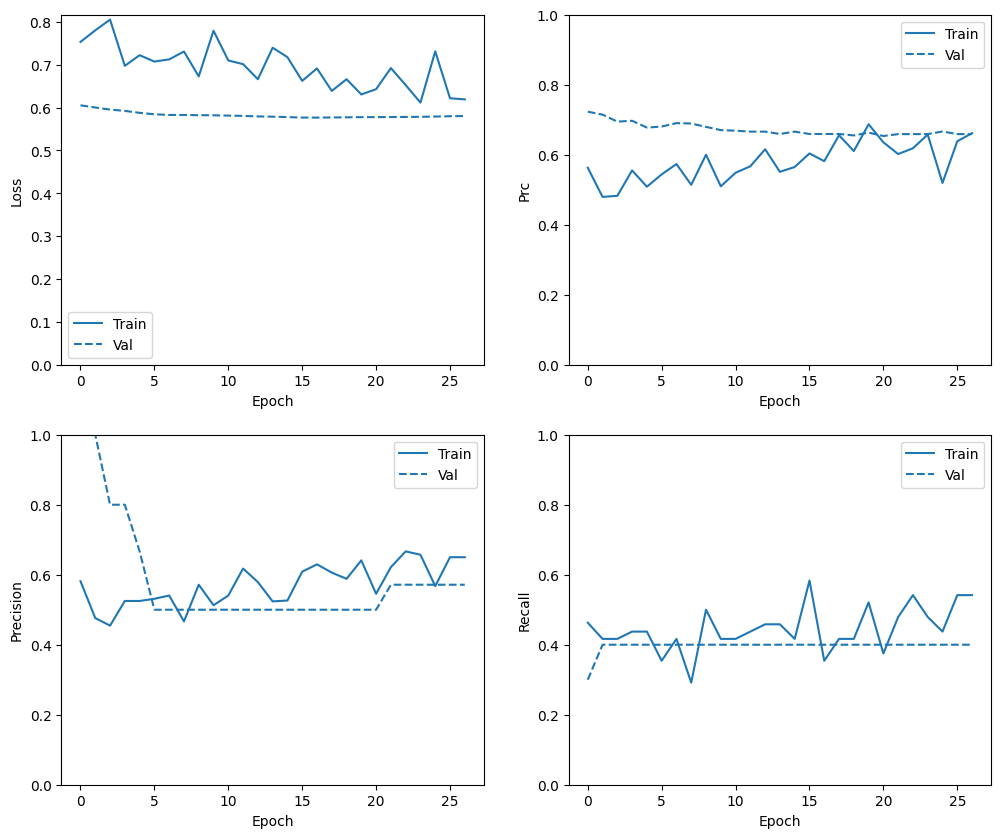

In [108]:
plot_metrics(history)
#plt.show()

In [109]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_mean.append(value)

1/1 [==============================] - 0s 21ms/step
loss :  0.7750511765480042
tp :  1.0
fp :  2.0
tn :  5.0
fn :  7.0
accuracy :  0.4000000059604645
precision :  0.3333333432674408
recall :  0.125
auc :  0.589285671710968
prc :  0.6158353090286255


True Negatives:  5
False Positives:  2
False Negatives:  7
True Positives:  1
Total:  8


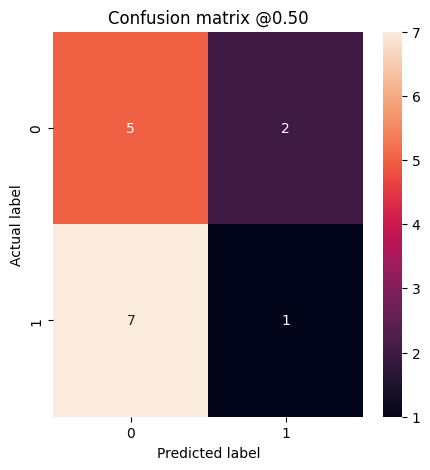

In [110]:
plot_cm(y_test, predictions_test)
#plt.show()

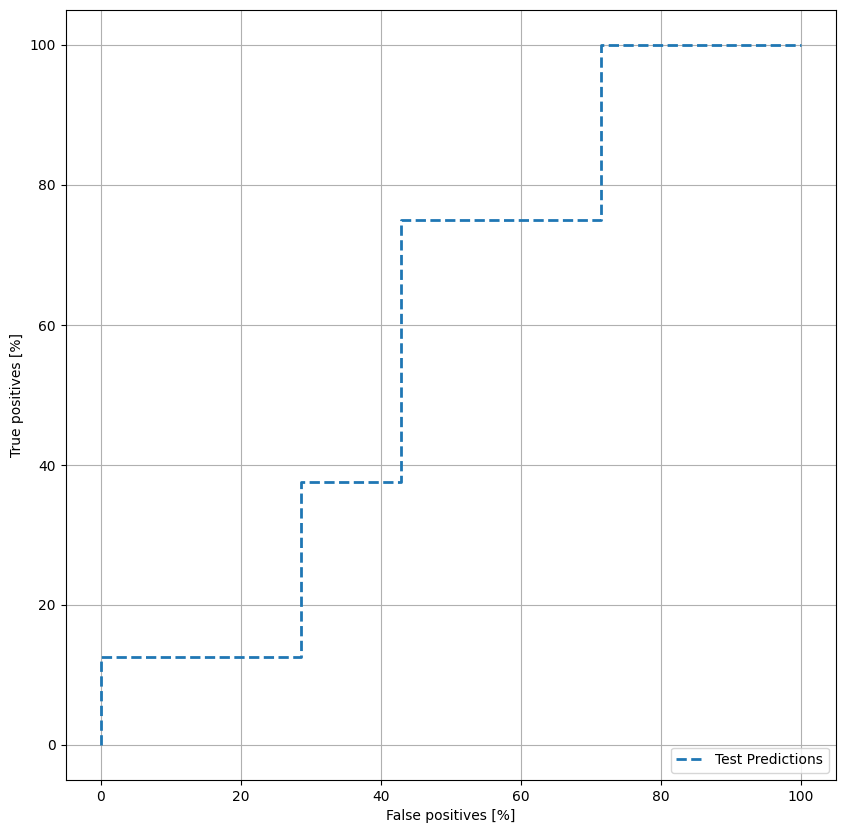

In [111]:
plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [112]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [113]:
#STOP

## 2.4 CNN Model with 32 Lines

### 2.4.1 Load Prepared Dataset

In [114]:
#columns to drop
columns = ['image', 'algo']

df = df_damage_thirtytwo_mean.drop(columns=columns)

### 2.4.2 Split into sets for training, validation, and testing + use and save scaler

In [115]:
X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### 2.4.3 Experimentation

#### 2.4.3.1 Configurations

In [116]:
from numpy import unique
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))



EPOCHS = 500
BATCH_SIZE = 2050

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

units = 64
activation = 'relu'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
#output_activation = 'softmax'
optimizer = 'Adam'
learning_rate = 1e-3
filters_1 = 8
filters_2 = 16
filters_3 = 32
filters_4 = 12
kernel_size = 3
pool_size = 2
strides = 1

Before: (36,)
After: (36, 1)
Classes: 1


#### 2.4.3.2 Model

In [117]:
model = make_cnn_model(metrics=METRICS, 
                       loss='binary_crossentropy', 
                       optimizer=optimizer, 
                       learning_rate=learning_rate,
                       in_shape= in_shape,
                       kernel_size=kernel_size,
                       kernel_initializer=kernel_initializer,
                       pool_size=pool_size,
                       filters_1=filters_1,
                       filters_2=filters_2,
                       filters_3=filters_3,
                       filters_4=filters_4)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 34, 8)             32        
                                                                 
 conv1d_7 (Conv1D)           (None, 32, 16)            400       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16)            0         
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 8)                 2056      
                                                      

In [118]:
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_val, y_val), 
                    shuffle=True, 
                    epochs=EPOCHS, 
                    verbose=1,
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping])

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.7043 - tp: 14.0000 - fp: 14.0000 - tn: 50.0000 - fn: 43.0000 - accuracy: 0.5289 - precision: 0.5000 - recall: 0.2456 - auc: 0.5658 - prc: 0.5320 - val_loss: 0.6191 - val_tp: 2.0000 - val_fp: 2.0000 - val_tn: 14.0000 - val_fn: 9.0000 - val_accuracy: 0.5926 - val_precision: 0.5000 - val_recall: 0.1818 - val_auc: 0.6705 - val_prc: 0.5673
Epoch 2/500
1/1 [==============================] - 0s 59ms/step - loss: 0.6539 - tp: 8.0000 - fp: 8.0000 - tn: 49.0000 - fn: 41.0000 - accuracy: 0.5377 - precision: 0.5000 - recall: 0.1633 - auc: 0.6497 - prc: 0.5962 - val_loss: 0.6152 - val_tp: 3.0000 - val_fp: 3.0000 - val_tn: 13.0000 - val_fn: 8.0000 - val_accuracy: 0.5926 - val_precision: 0.5000 - val_recall: 0.2727 - val_auc: 0.6932 - val_prc: 0.6093
Epoch 3/500
1/1 [==============================] - 0s 59ms/step - loss: 0.7025 - tp: 13.0000 - fp: 11.0000 - tn: 46.0000 - fn: 36.0000 - accuracy: 0.5566 - precision: 0.5417 - recall

In [119]:
early_stopping.stopped_epoch

15

In [120]:
#plot_loss(history, "Bias", 0)
#plt.show()

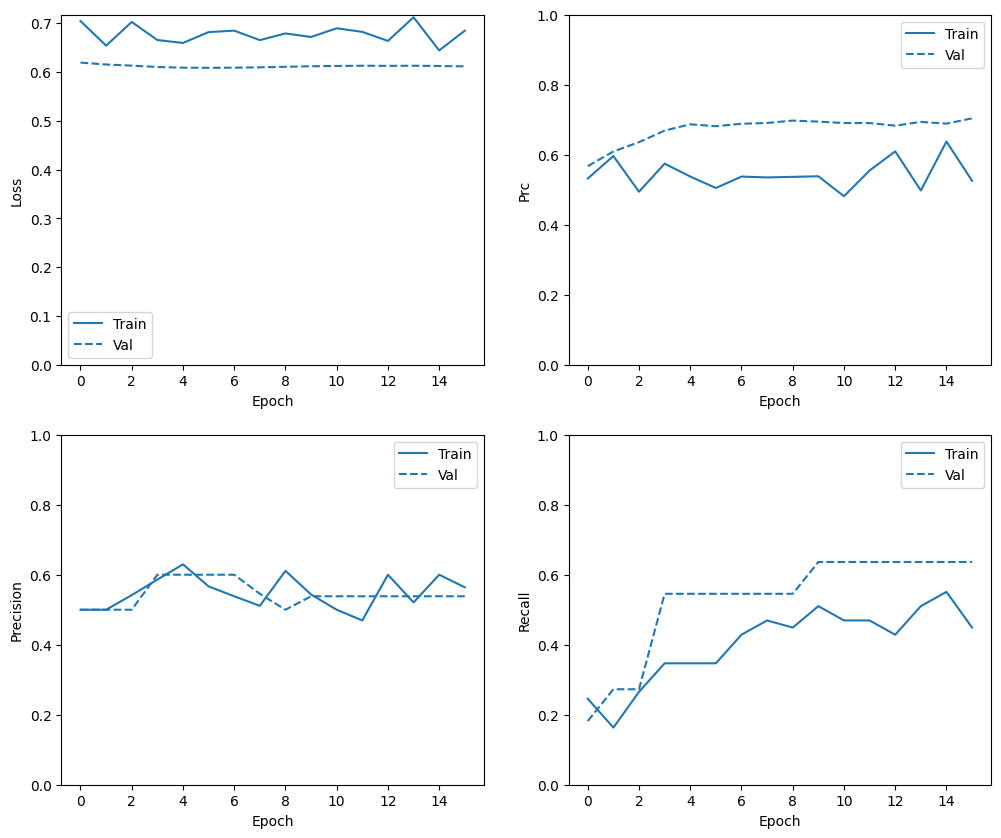

In [121]:
plot_metrics(history)
#plt.show()

In [122]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_mean.append(value)

1/1 [==============================] - 0s 20ms/step
loss :  0.7415717840194702
tp :  2.0
fp :  2.0
tn :  5.0
fn :  6.0
accuracy :  0.46666666865348816
precision :  0.5
recall :  0.25
auc :  0.4107142686843872
prc :  0.5356255173683167


True Negatives:  5
False Positives:  2
False Negatives:  6
True Positives:  2
Total:  8


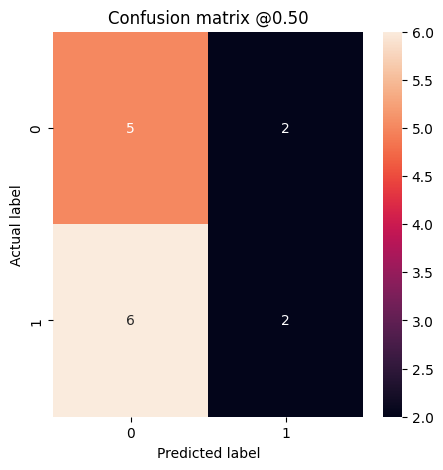

In [123]:
plot_cm(y_test, predictions_test)
#plt.show()

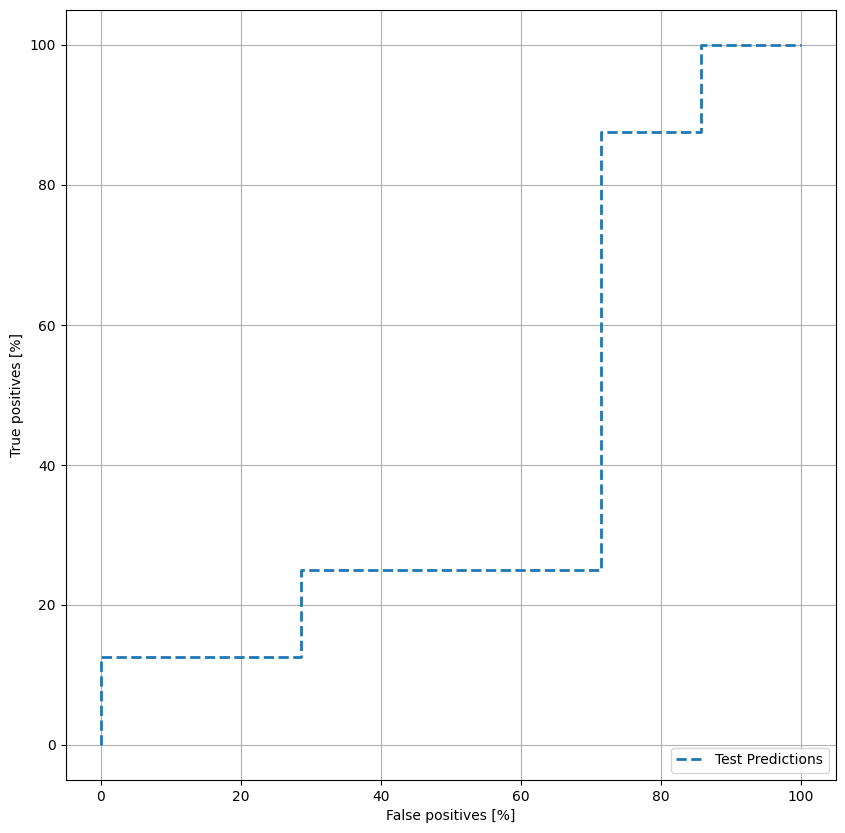

In [124]:
plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [125]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [126]:
#STOP

# Summarry

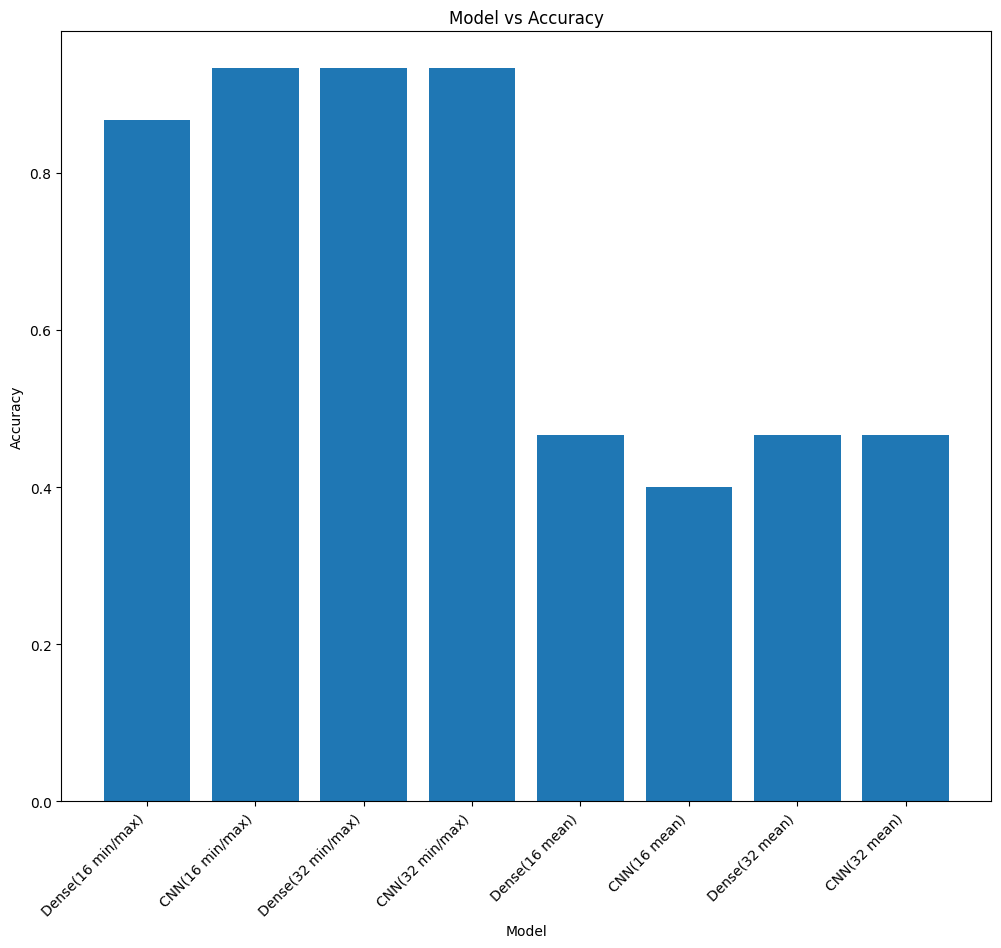

In [133]:
#accuracy_sixteen_min_max = []
#accuracy_thirtytwo_min_max = []
#accuracy_sixteen_mean = []
#accuracy_thirtytwo_mean = []

col = [1, 2, 3, 4, 5, 6, 7, 8]
accuracy = accuracy_sixteen_min_max + accuracy_thirtytwo_min_max + accuracy_sixteen_mean + accuracy_thirtytwo_mean

tick_label = ['Dense(16 min/max)', 'CNN(16 min/max)', 'Dense(32 min/max)', 'CNN(32 min/max)', 'Dense(16 mean)', 'CNN(16 mean)', 'Dense(32 mean)', 'CNN(32 mean)']

plt.bar(col, accuracy, tick_label = tick_label, width = 0.8)
    
plt.xticks(rotation=45, horizontalalignment="right")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model vs Accuracy')

plt.show()   